**Exercise 1** \
Create 2D Gaussian distribution centred at origin \
Pick local maximum \
Walk from centre and see intensity distribution 


**Exercise 2** \
Create Mixture of gaussians \
Pick local maxima\
Walk from centre and see intensity distribution 

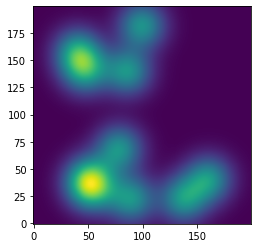

In [31]:
import numpy as np
from skimage.feature import peak_local_max
import scipy
from scipy import signal
from scipy import ndimage as ndi
from scipy.spatial import distance
import sys, copy, os
import matplotlib.pyplot as plt



"""
Create 2D gaussian kernel and place it at random location 
https://stackoverflow.com/questions/66580517/creating-a-gaussian-2d-array-with-mean-1-at-specificed-location
"""


N = 100 # kernel size
k1d = signal.gaussian(N, std=15) # returns row vector
k1d = k1d.reshape(N,1) # reshape k1d into column vector
kernel = np.outer(k1d,k1d) #generating Gaussian kernel (using outer product)
# plt.imshow(kernel)
# plt.gca().invert_yaxis()
# plt.show()

#generate image with gaussian at random location
size = 200 # image size

#xy coordinates of Gaussian in image
# x = [120,150,90,80,30]
# y = [90,120,150,40]

x = np.random.randint(size, size=10)
y = np.random.randint(size, size=10)

A = np.zeros((size,size))
A[y,x] = 1 #Generate peak at specified coordinates
# plt.imshow(A)
# plt.gca().invert_yaxis()
# plt.show()
img = signal.convolve2d(A,kernel, mode='same') #Generate image – convolve delta peak with Gaussian
plt.imshow(img)
plt.gca().invert_yaxis()
plt.show()


9  peaks identified...
Creating plot...


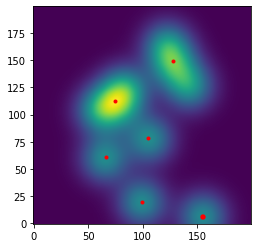

5 peak(s) too close to edge
Sampling from 4 peaks


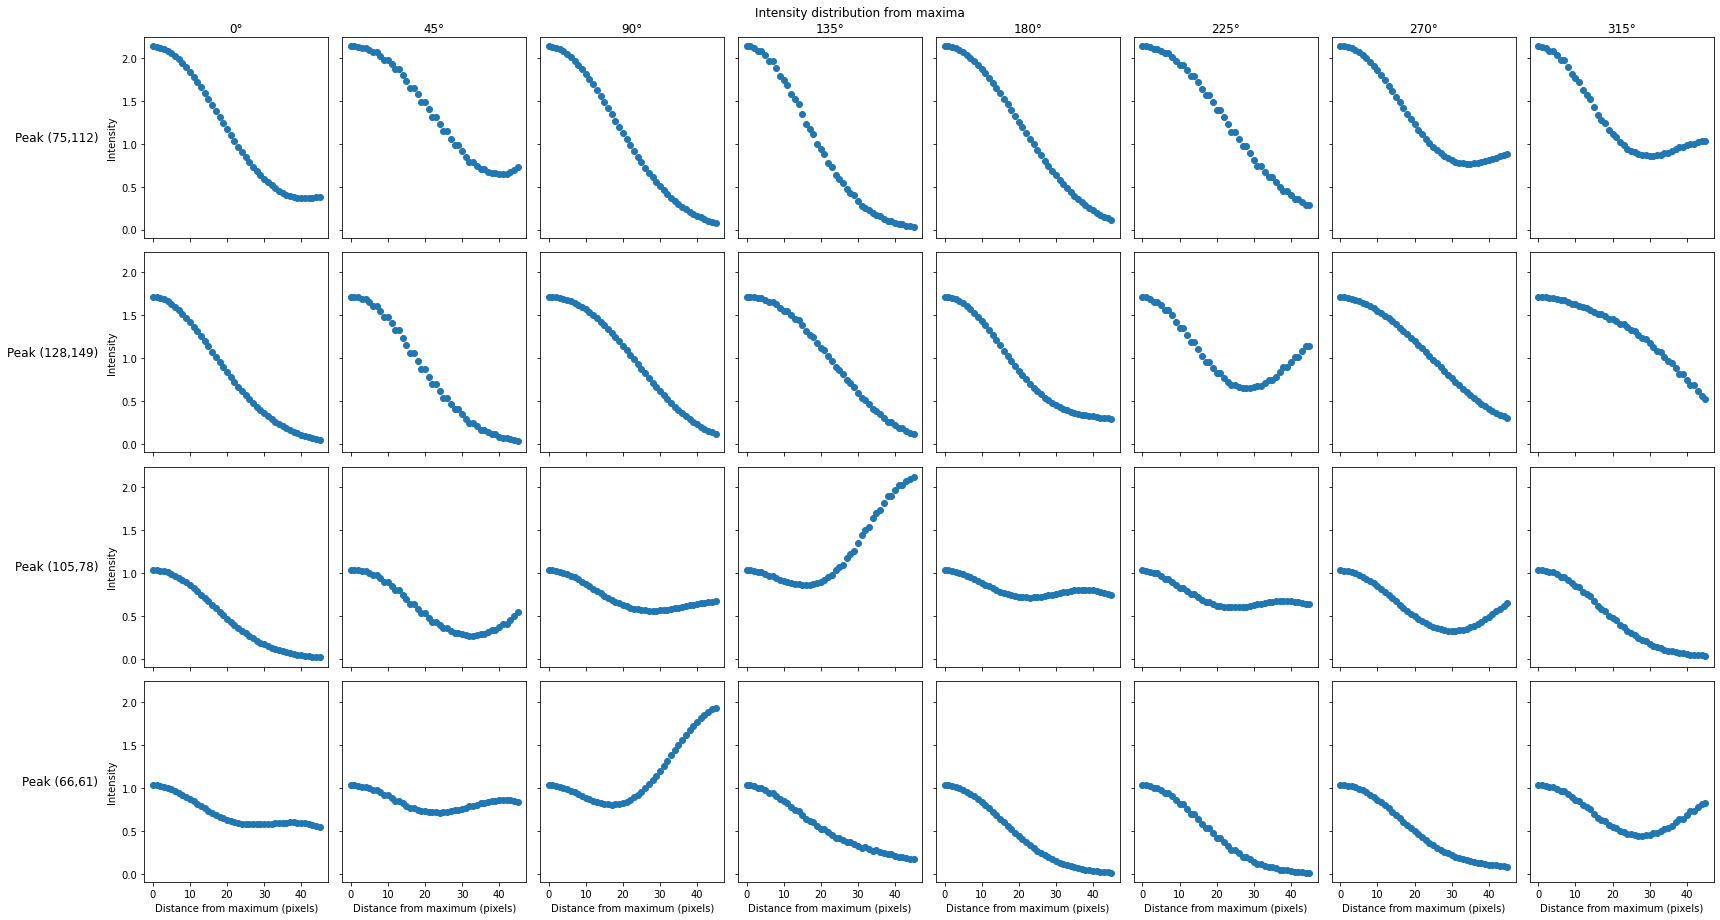

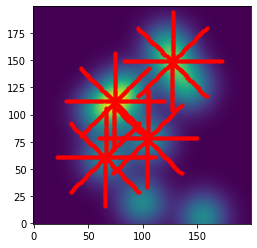

In [78]:
"""
find coordinates of local maximum

draw lines radiating from local maximum:
https://stackoverflow.com/questions/28417604/plotting-a-line-from-a-coordinate-with-and-angle
"""
# find peaks and coordinates
coords = peak_local_max(img, min_distance=1) #coords — N rows (N = number of peaks), 2 columns (x- and y-coordinates)
coords_rows, coords_cols = coords.shape #number of rows = number of peaks
y_peaks = coords[:,0] #row vector with y coordinates of peaks (N elements — N = number of peaks)
x_peaks = coords[:,1] #row vector with x coordinates of peaks (N elements — N = number of peaks)

N_peaks = len(x_peaks)
print(N_peaks, " peaks identified...")


print('Creating plot...')
plt.imshow(img)
plt.autoscale(False)
plt.plot(x_peaks,y_peaks, 'r.')
plt.gca().invert_yaxis()
plt.show()

"""
draw lines radiating from local maximum
"""
# define angle and length of line from local maximum
theta = np.arange(0,360,45) #angles sampled
r = 45 #length of line


# remove points too close to edge (defined using length of line sampled from local max)
array = np.ones((size,size), dtype=int)
array[:,[0,-1]] = array[[0,-1]] = 0
dfromedge = ndi.distance_transform_cdt(array, metric='chessboard')
disttoosmall = dfromedge[y_peaks,x_peaks] < r

x_peaks = np.delete(x_peaks, np.argwhere(disttoosmall==True))
y_peaks = np.delete(y_peaks, np.argwhere(disttoosmall==True))

N_angles = len(theta)
N_peaks = len(x_peaks)
N_peaks_disttoosmall = sum(disttoosmall)

print(N_peaks_disttoosmall, "peak(s) too close to edge")
print(f'Sampling from {N_peaks} peaks')

# find end points:
#   for each angle
#       for each peak
#           compute end point of line drawn out from peak

#initialising matrices for x and y coordinates for end poiNnts
#   rows(i) — N_rows = number of angles sampled
#   columns(j) – N_cols = number of peaks
#   value at i,j = x, y coordinates of particular end point at particular angle from peak
endy = np.zeros((N_angles,N_peaks))
endx = np.zeros((N_angles,N_peaks))

for i, angle in enumerate(theta):
    endy[i,:] = y_peaks + r*np.sin(np.radians(angle))
    endx[i,:] = x_peaks + r*np.cos(np.radians(angle))

endy = endy.astype(int) 
#row vector with y-coordinates of end points of line drawn from maximum – N_cols = N_peaks; N_rows = N_angles

endx = endx.astype(int) 
#row vector with x-coordinates of end points of line drawn from maximum — N_cols = N_peaks; N_rows = N_angles
# print(endx)
# print(endy)

#for each angle
#   for each peak
#       compute array of x and y coordinates, with interval 1 (to extract intensity values)
# i = len(theta) – number of angles sampled
# j = coords_rows – number of peaks
# k = r – number of points between peak and end point
# value at i,j,k = x,y coordinates of points on line drawn between maximum and end point

x = np.zeros((N_angles,N_peaks,r+1))
y = np.zeros((N_angles,N_peaks,r+1))

for i in range(N_angles):
    for j in range(N_peaks):
        y[i,j,:] = np.linspace(y_peaks[j], endy[i,j], r+1)
        x[i,j,:] = np.linspace(x_peaks[j], endx[i,j], r+1)

y=y.astype(int)
x=x.astype(int)

# print('x.shape=',x.shape)
# print('y.shape=',y.shape)


"""
calculate intensities and plotting:
"""
#   for each angle
#       for each peak
#           for each point in line between maximum and end point
#               find intensity
# i = len(theta) – number of angles sampled
# j = coords_rows – number of peaks
# k = r – number of points between peak and end point
# value at i,j,k = intensity values at particular x,y coordinates
I = img[y,x]

"""
plotting
"""
rows = N_peaks
cols = N_angles
fig, ax = plt.subplots(rows,cols,figsize=(3*N_angles,3*N_peaks+1),sharex=True,sharey=True)

fig.suptitle('Intensity distribution from maxima')
plt.setp(ax[-1,:],xlabel = 'Distance from maximum (pixels)')
plt.setp(ax[:,0],ylabel = 'Intensity')

for i in range(N_peaks): #for each peak
    for j in range(N_angles): #for each angle
        x_ax = np.arange(0,len(x[j,i,:]),1)
        ax[i,j].scatter(x_ax, I[j,i,:])

#labelling rows and columns of subplots (https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots)
col_labels = [f'{theta[i]}°' for i in range(N_angles)]
row_labels = [f'Peak ({x_peaks[i]},{y_peaks[i]})' for i in range(N_peaks)]

pad = 5 #in points

for axes, col in zip(ax[0], col_labels):
    axes.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for axes, row in zip(ax[:,0], row_labels):
    axes.annotate(row, xy=(0, 0.5), xytext=(-axes.yaxis.labelpad - pad, 0),
                xycoords=axes.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

fig.tight_layout()
plt.show()


xflat = x.ravel()
yflat = y.ravel()

plt.figure()
plt.imshow(img)
plt.autoscale(False)
plt.plot(xflat,yflat, 'r.')
plt.gca().invert_yaxis()
plt.show()




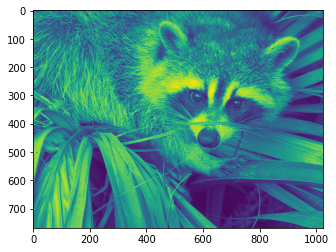

[[640.         639.2002816  638.40112782 ... 637.60254077 638.40112782
  639.2002816 ]
 [639.40050047 638.60003132 637.80012543 ... 637.00078493 637.80012543
  638.60003132]
 [638.80200375 638.0007837  637.20012555 ... 636.40003143 637.20012555
  638.0007837 ]
 ...
 [638.20451268 637.40254157 636.60113101 ... 635.80028311 636.60113101
  637.40254157]
 [638.80200375 638.0007837  637.20012555 ... 636.40003143 637.20012555
  638.0007837 ]
 [639.40050047 638.60003132 637.80012543 ... 637.00078493 637.80012543
  638.60003132]]


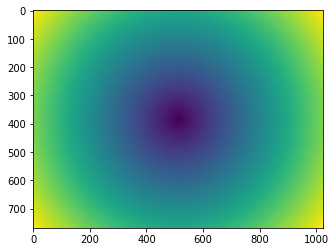

[[20 19 19 ... 19 19 19]
 [19 19 19 ... 19 19 19]
 [19 19 19 ... 19 19 19]
 ...
 [19 19 19 ... 19 19 19]
 [19 19 19 ... 19 19 19]
 [19 19 19 ... 19 19 19]]


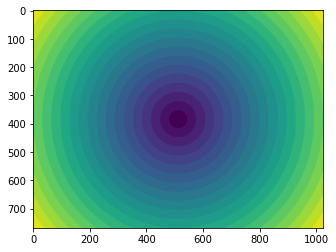

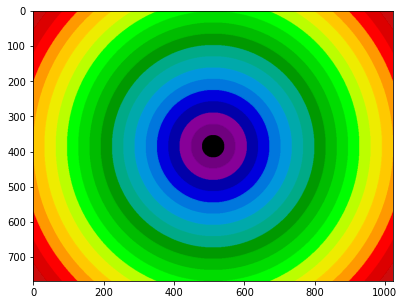

In [13]:
"""
Radial averaging
"""
f = scipy.misc.face(gray=True)
plt.figure()
plt.imshow(f)
plt.show()
sx, sy = f.shape
X, Y = np.ogrid[0:sx, 0:sy]
# print(X)
# print(Y)


r = np.hypot(X - sx/2, Y - sy/2)
print(r)
plt.figure()
plt.imshow(r)
plt.show()

rbin = (20* r/r.max()).astype(int)
print(rbin)
plt.figure()
plt.imshow(rbin)
plt.show()
radial_mean = ndi.mean(f, labels=rbin, index=np.arange(1, rbin.max() +1))

plt.figure(figsize=(5, 5))
plt.axes([0, 0, 1, 1])
plt.imshow(rbin, cmap=plt.cm.nipy_spectral)
# plt.axis('off')

plt.show()

In [ ]:
"""
Calculating spatial autocorrelations
"""

./pickle/imgclass found, opening...
33  peaks identified...
Creating plot...


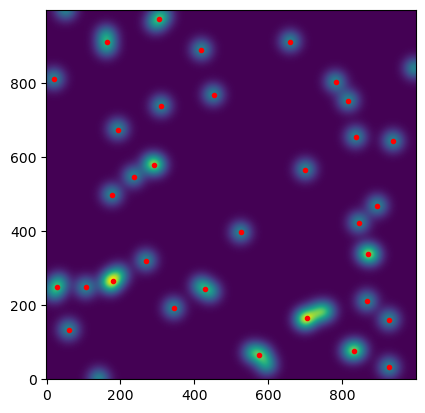

4 peak(s) too close to edge
Sampling from 29 peaks
drawing radial lines...
calculating intensities...
radialav_list.shape =  (33, 50)
radialstd_list.shape =  (33, 50)
x_ax.shape =  (50,)


<Figure size 640x480 with 0 Axes>

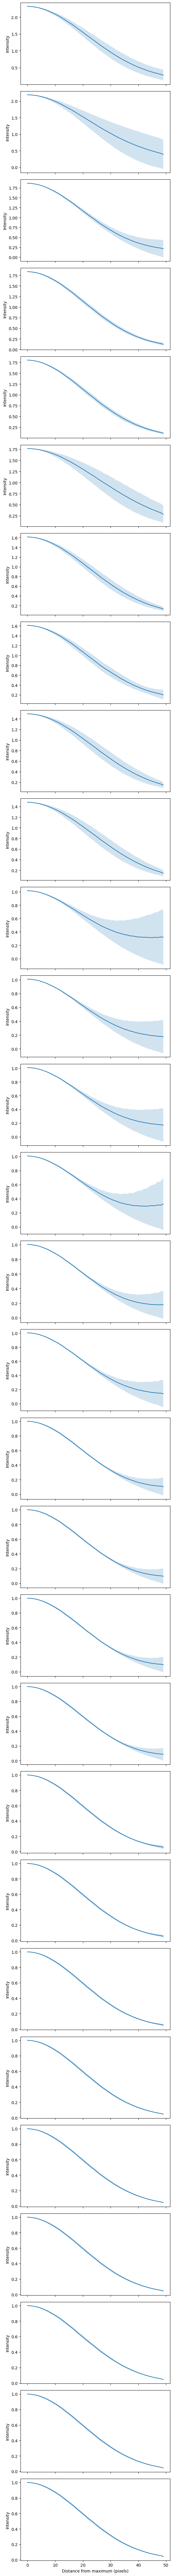

In [27]:
import numpy as np
from skimage.feature import peak_local_max
import scipy
from scipy import signal, stats
from scipy import ndimage as ndi
from scipy.spatial import distance
import sys, copy, os
import matplotlib.pyplot as plt
from distributions import GenerateImage, GenerateDistributions

"""
https://stackoverflow.com/questions/21242011/most-efficient-way-to-calculate-radial-profile
https://stackoverflow.com/questions/48842320/what-is-the-best-way-to-calculate-radial-average-of-the-image-with-python
https://levelup.gitconnected.com/a-simple-method-to-calculate-circular-intensity-averages-in-images-4186a685af3

"""

# def calc_radialdist(img, coords, r):

#     x_peaks = coords[:,1]
#     y_peaks = coords[:,0]
#     center = (x_peaks,y_peaks)
#     N_peaks = len(x_peaks)

#     y, x = np.indices((img.shape)) #y = list of indices row-wise, x - list of indices column wise 

#     distmap_all = np.empty(N_peaks)
#     intensities_all = np.empty(N_peaks)
    
#     for i, coords in enumerate(center):        
#         distmap = np.sqrt((x - center[i,0])**2 + (y - center[i,1])**2) #based on distance formula — computes Euclidean distance from centre for all points in array, creating distance field
#         distmap = distmap.astype(int)

#         distmap = distmap.ravel()
#         intensities = img.ravel()
        
#         #cutting off distances larger than defined radius
#         mask = (distmap>r)
#         mask = mask.ravel()

#         distmap_all[i] = np.delete(distmap, mask)
#         intensities_all[i] = np.delete(intensities, mask)

#     return distmap_all, intensities_all


Gen_new_img = False
imgsize = 1000
N_blobs = 50

r = 50
dtheta = 1
pl_intensities=False
pl_lines=False
pseudoradav=False

gen_img = GenerateImage(Gen_new_img,imgsize,N_blobs)
gen_dists = GenerateDistributions(gen_img.img,r,dtheta,pl_intensities,pl_lines,pseudoradav)

img = gen_img.img
coords = gen_dists.coords
r = 50

# x_peaks = coords[:,1]
# y_peaks = coords[:,0]
# center = (x_peaks,y_peaks)
# print(center)
N_peaks = len(x_peaks)

y, x = np.indices((img.shape)) #y = list of indices row-wise, x - list of indices column wise 

radialav_list = np.empty([N_peaks,r])
radialstd_list = np.empty([N_peaks,r])

for i, coord in enumerate(coords):
    x_img = coord[1]
    y_img = coord[0]        
    distmap = np.sqrt((x - x_img)**2 + (y - y_img)**2) #based on distance formula — computes Euclidean distance from centre for all points in array, creating distance field
    distmap = distmap.astype(int)

    distmap = distmap.ravel()
    intensities = img.ravel()
    
    #cutting off distances larger than defined radius
    mask = (distmap>r)
    mask = mask.ravel()

    distmap = np.delete(distmap, mask)
    intensities = np.delete(intensities, mask)

    radialav_list[i], mbinedges, mbinnumber = stats.binned_statistic(distmap, intensities,statistic='mean',bins=50)
    radialstd_list[i], sbinedges, sbinnumber = stats.binned_statistic(distmap, intensities, statistic='std',bins=50)

print('radialav_list.shape = ',radialav_list.shape)
print('radialstd_list.shape = ',radialstd_list.shape)

x_ax = np.arange(0,r,1)
print('x_ax.shape = ',x_ax.shape)

rows = gen_dists.N_peaks
plt.figure()
fig, ax = plt.subplots(rows, ncols=1, figsize=(6,3*rows+1),sharex=True)
plt.setp(ax[-1],xlabel = 'Distance from maximum (pixels)')
plt.setp(ax[:],ylabel = 'Intensity')

for i in range(rows):
    ax[i].plot(x_ax, radialav_list[i,:])
    ax[i].fill_between(x_ax, radialav_list[i,:]-radialstd_list[i,:], radialav_list[i,:]+radialstd_list[i,:], alpha=0.2)

fig.tight_layout()
plt.show()



creating pandas dataframe...
       r  intensity
0     50   0.001402
1     50   0.001546
2     49   0.001697
3     49   0.001855
4     48   0.002018
...   ..        ...
7966  50   0.009146
7967  50   0.008866
7968  50   0.008556
7969  50   0.008221
7970  50   0.007863

[7971 rows x 2 columns]
plotting...


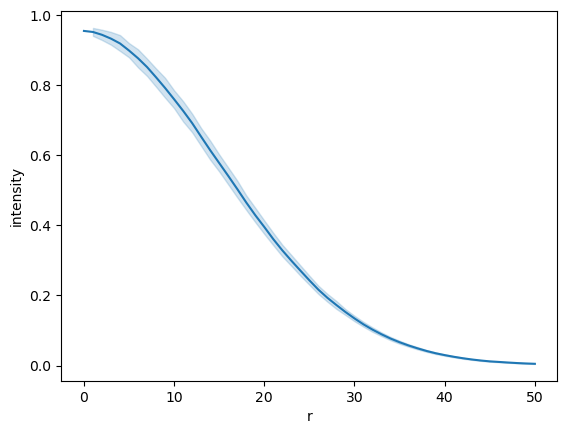

In [7]:

"""
Using pandas dataframe and seaborn plotting library to visualise mean and std
"""
print('creating pandas dataframe...')
dataset = pd.DataFrame({'r': r_ravel, 'intensity': kernel_ravel}, columns=['r','intensity'])
print(dataset)

print('plotting...')
plt.figure()
sns.lineplot(data=dataset, x="r", y="intensity", err_style='band', ci=95)
plt.show()




calculating radial averages...
plotting radial SUMS...


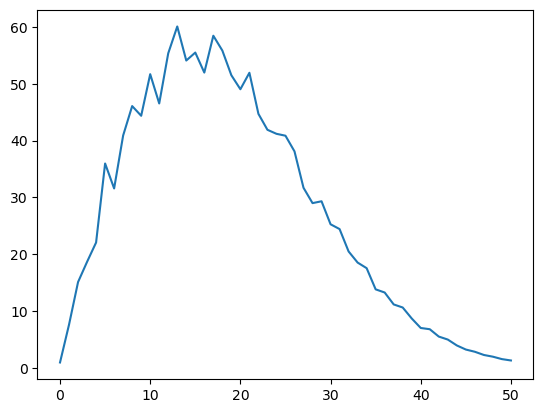

plotting radial averages...


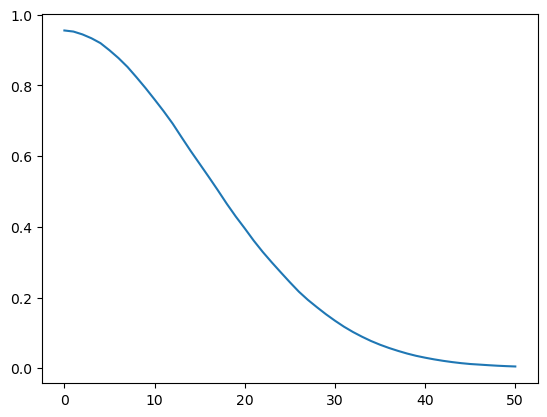

In [8]:

"""
Using numpy arrays to calculate radial mean
"""

print('calculating radial averages...')

tbin = np.bincount(r_ravel, kernel_ravel) 
#r - distance from centre of peak (acts as Euclidean distance mask), 
#kernel - each element is the intensity value at each pixel
#np.bincount — sums intensity values as a function of distance from the peak
#tbin - a 1d array, each element in array corresponds to the 
#   summed intensities of groups of pixels that are equidistant from the centre of the peak

print('plotting radial SUMS...')
plt.figure()
plt.plot(tbin)
plt.show()

nr = np.bincount(r_ravel)
# nr — a 1d array, each element is a count of the number of pixels that are a defined distance from the centre of the peak

radialmean = tbin / nr
# radial profile - a 1d array, each element is the radially averaged intensity value 
#   (i.e. the intensity normalised to the count of pixels equidistant from peak centre)

print('plotting radial averages...')
plt.figure()
plt.plot(radialmean)
plt.show()


calculating radial mean and std by scipy...
radialmean_scipy =  [0.99888951 0.99556972 0.98677403 0.97480142 0.95977066 0.93768244
 0.91359208 0.88625623 0.85438301 0.82131395 0.78645088 0.75074025
 0.71291228 0.670965   0.62974522 0.59053618 0.55141477 0.51160257
 0.47074547 0.43250812 0.39707264 0.36061369 0.32731428 0.29673185
 0.26750578 0.23888365 0.21154339 0.18789462 0.16694495 0.14691613
 0.12860107 0.11168607 0.09683104 0.08371542 0.07184914 0.06162541
 0.05269469 0.04483122 0.03772494 0.03163987 0.02666095 0.02225463
 0.01842817 0.01515809 0.01243727 0.01023677 0.00837891 0.00680972
 0.00549823 0.00400603]
binedges =  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]
binnumber =  [50 50 50 ... 50 50 50]
plotting radial mean...


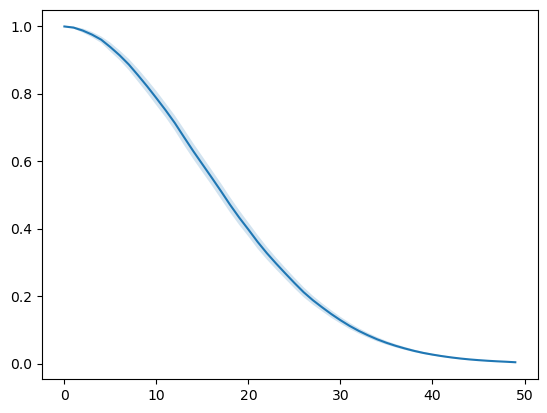

plotting radial std...


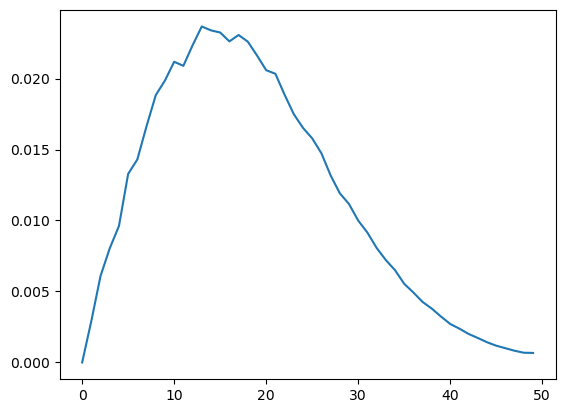

In [8]:
x_peaks = coords[:,1]
y_peaks = coords[:,0]
center = (x_peaks,y_peaks)
N_peaks = len(x_peaks)

y, x = np.indices((img.shape)) #y = list of indices row-wise, x - list of indices column wise 


    distmap = np.sqrt((x - center[i,0])**2 + (y - center[i,1])**2) #based on distance formula — computes Euclidean distance from centre for all points in array, creating distance field
    distmap = distmap.astype(int)

    distmap = distmap.ravel()
    intensities = img.ravel()
    
    #cutting off distances larger than defined radius
    mask = (distmap>r)
    mask = mask.ravel()

    distmap_all[i] = np.delete(distmap, mask)
    intensities_all[i] = np.delete(intensities, mask)

"""
using scipy stats library to calculate radial mean and standard devaiton
"""

print("calculating radial mean and std by scipy...")
radialmean_scipy, mbinedges, mbinnumber = stats.binned_statistic(r_ravel, kernel_ravel,statistic='mean',bins=50)
radialstd_scipy, sbinedges, sbinnumber = stats.binned_statistic(r_ravel, kernel_ravel, statistic='std',bins=50)

binwidth = (mbinedges[1] - mbinedges[0])
bincentres = mbinedges[1:] - binwidth/2

# print("radialmean_scipy = ", radialmean_scipy)
# print("binedges = ", mbinedges)
# print("binnumber = ", mbinnumber)

x = np.arange(0,50,1)
print("plotting radial mean...")
plt.figure()
plt.plot(x, radialmean_scipy, label='radialmean')
plt.fill_between(x, radialmean_scipy-radialstd_scipy, radialmean_scipy+radialstd_scipy, alpha=0.2)
plt.show()

print("plotting radial std...")
plt.figure()
plt.plot(x, radialstd_scipy, label='radialstd')
plt.show()







In [ ]:

"""
Using pandas dataframe and seaborn plotting library to visualise mean and std
"""
print('creating pandas dataframe...')
dataset = pd.DataFrame({'r': r_ravel, 'intensity': kernel_ravel}, columns=['r','intensity'])
print(dataset)

print('plotting...')
plt.figure()
sns.lineplot(data=dataset, x="r", y="intensity", err_style='band', ci=95)
plt.show()



"""
Using numpy arrays to calculate radial mean
"""

print('calculating radial averages...')

tbin = np.bincount(r_ravel, kernel_ravel) 
#r - distance from centre of peak (acts as Euclidean distance mask), 
#kernel - each element is the intensity value at each pixel
#np.bincount — sums intensity values as a function of distance from the peak
#tbin - a 1d array, each element in array corresponds to the 
#   summed intensities of groups of pixels that are equidistant from the centre of the peak

print('plotting radial SUMS...')
plt.figure()
plt.plot(tbin)
plt.show()

nr = np.bincount(r_ravel)
# nr — a 1d array, each element is a count of the number of pixels that are a defined distance from the centre of the peak

radialmean = tbin / nr
# radial profile - a 1d array, each element is the radially averaged intensity value 
#   (i.e. the intensity normalised to the count of pixels equidistant from peak centre)

print('plotting radial averages...')
plt.figure()
plt.plot(radialmean)
plt.show()


"""
using scipy stats library to calculate radial mean and standard devaiton
"""

print("calculating radial mean and std by scipy...")
radialmean_scipy, mbinedges, mbinnumber = stats.binned_statistic(r_ravel, kernel_ravel,statistic='mean',bins=50)
radialstd_scipy, sbinedges, sbinnumber = stats.binned_statistic(r_ravel, kernel_ravel, statistic='std',bins=50)

binwidth = (mbinedges[1] - mbinedges[0])
bincentres = mbinedges[1:] - binwidth/2

# print("radialmean_scipy = ", radialmean_scipy)
# print("binedges = ", mbinedges)
# print("binnumber = ", mbinnumber)

print("plotting radial mean...")
plt.figure()
plt.plot(radialmean_scipy, label='radialmean')
plt.show()

print("plotting radial std...")
plt.figure()
plt.plot(radialstd_scipy, label='radialstd')
plt.show()







/Users/eugene/OneDrive - Nexus365/PhD/3. Rotation 1/Data/5. Tomogram test data
./pickle/imgclass found, opening...
33  peaks identified...
Creating plot...


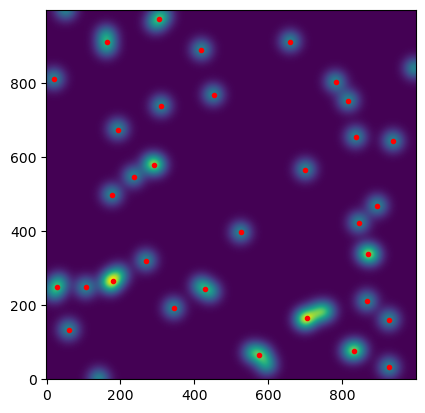

16 peak(s) too close to edge
Sampling from 17 peaks
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [3]:
import numpy as np
from skimage.feature import peak_local_max
import scipy
from scipy import signal, stats
from scipy import ndimage as ndi
from scipy.spatial import distance
import sys, copy, os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from distributions import GenerateImage, GenerateDistributions

Gen_new_img = False
imgsize = 1000
N_blobs = 50

Plot_Lines=False
r = 150

gen_img = GenerateImage(Gen_new_img,imgsize,N_blobs)
gen_dists = GenerateDistributions(gen_img.img,r,Plot_Lines)

#getting xy coordinates of peaklist
N_peaks = gen_dists.N_peaks
x_peaks = gen_dists.x_peaks
y_peaks = gen_dists.y_peaks
peak_number = np.arange(N_peaks)







./pickle/imgclass found, opening...
33  peaks identified...
Creating plot...


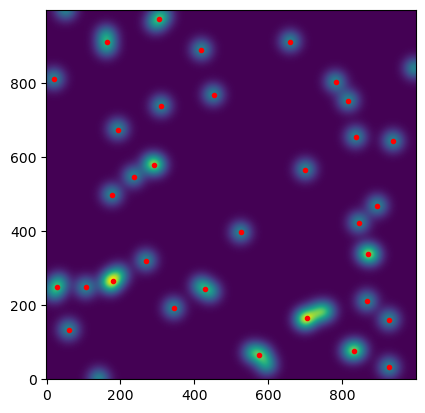

11 peak(s) too close to edge
Sampling from 22 peaks
drawing radial lines...
calculating intensities...


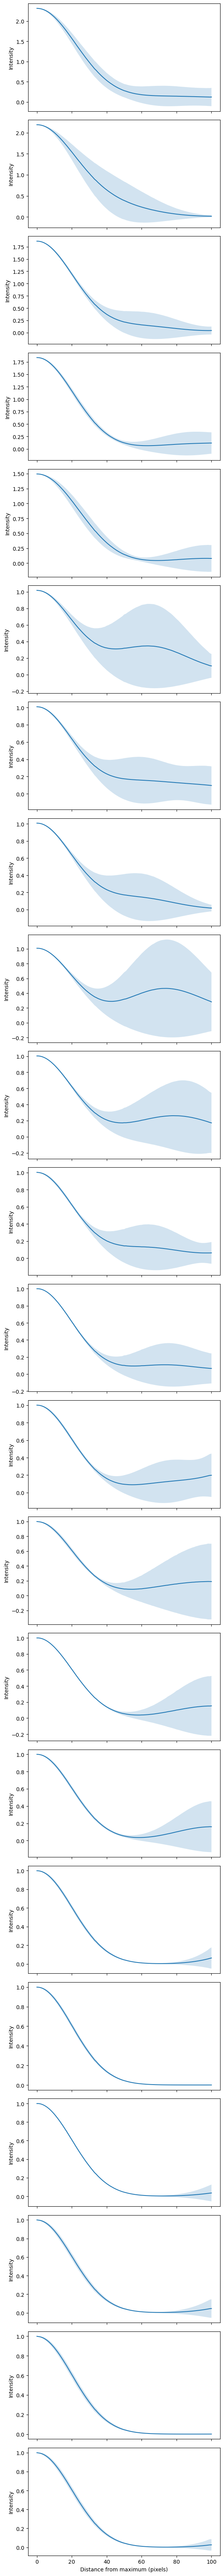

In [12]:
import numpy as np
from skimage.feature import peak_local_max
import scipy
from scipy import stats
from scipy.spatial import distance
import sys, copy, os
import matplotlib.pyplot as plt
from distributions import GenerateImage, GenerateDistributions

Gen_new_img = False
imgsize = 1000
N_blobs = 50

r = 100
dtheta = 1
pl_intensities=False
pl_lines=False

gen_img = GenerateImage(Gen_new_img,imgsize,N_blobs)
gen_dists = GenerateDistributions(gen_img.img,r,dtheta,pl_intensities,pl_lines)

I = gen_dists.I

I_mean = np.mean(gen_dists.I, axis=0)
I_std = np.std(gen_dists.I, axis=0)

rows = gen_dists.N_peaks
fig, ax = plt.subplots(rows, ncols=1,figsize=(6, 3*rows+1),sharex=True)
#fig.suptitle('Intensity distribution from maxima')
plt.setp(ax[-1],xlabel = 'Distance from maximum (pixels)')
plt.setp(ax[:],ylabel = 'Intensity')

x_ax = np.arange(0,gen_dists.r+1,1)

for i in range(rows):
    ax[i].plot(x_ax, I_mean[i,:])
    ax[i].fill_between(x_ax, I_mean[i,:]-I_std[i,:], I_mean[i,:]+I_std[i,:], alpha=0.2)

fig.tight_layout()
plt.show()


# N_points = gen_dists.r+1

# distances = np.zeros((gen_dists.N_angles,gen_dists.N_peaks,gen_dists.r+1))
# for i in range(gen_dists.N_angles):
#     for j in range(gen_dists.N_peaks):
#         distances[i,j,:] = np.sqrt((gen_dists.y[i,j,:]-gen_dists.y_peaks[j])**2+(gen_dists.x[i,j,:]-gen_dists.x_peaks[j])**2)

# distances = distances.astype(int)





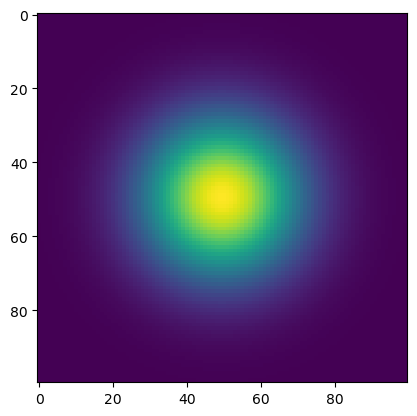

calculating radial mean and std by scipy...
radialmean_scipy =  [0.99888951 0.99556972 0.98677403 0.97480142 0.95977066 0.93768244
 0.91359208 0.88625623 0.85438301 0.82131395 0.78645088 0.75074025
 0.71291228 0.670965   0.62974522 0.59053618 0.55141477 0.51160257
 0.47074547 0.43250812 0.39707264 0.36061369 0.32731428 0.29673185
 0.26750578 0.23888365 0.21154339 0.18789462 0.16694495 0.14691613
 0.12860107 0.11168607 0.09683104 0.08371542 0.07184914 0.06162541
 0.05269469 0.04483122 0.03772494 0.03163987 0.02666095 0.02225463
 0.01842817 0.01515809 0.01243727 0.01023677 0.00837891 0.00680972
 0.00549823 0.00400603]
radialmean.shape =  (50,)
binedges =  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]
binedges.shape =  (51,)
binnumber =  [50 50 50 ... 50 50 50]
binnumber.shape =  (8119,)
x.shape =  (50,)
plotting radial mean...


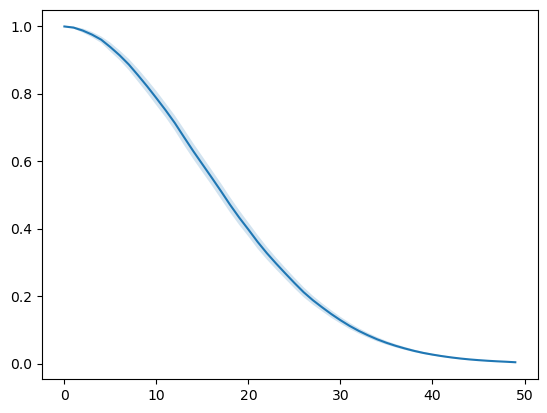

plotting radial std...


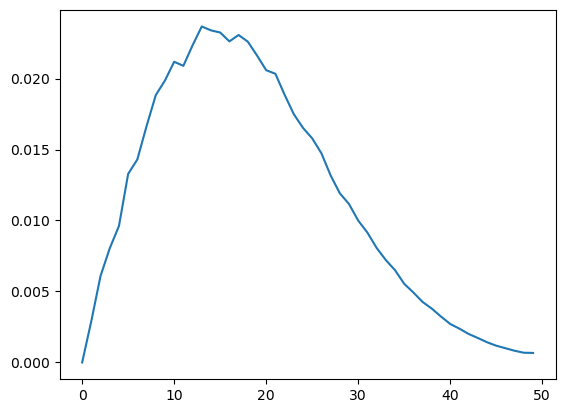

In [18]:
import numpy as np
from skimage.feature import peak_local_max
import scipy
from scipy import stats, signal
from scipy.spatial import distance
import sys, copy, os
import matplotlib.pyplot as plt
from distributions import GenerateImage, GenerateDistributions

N = 100 # kernel size
k1d = signal.gaussian(N, std=15) # returns row vector
k1d = k1d.reshape(N,1) # reshape k1d into column vector
kernel = np.outer(k1d,k1d) #generating Gaussian kernel (using outer product)
plt.imshow(kernel)
plt.show()

coords = peak_local_max(kernel, min_distance=10) #coords — N rows (N = number of peaks), 2 columns (x- and y-coordinates)
coords_rows, coords_cols = coords.shape #number of rows = number of peaks

#print(coords)
#print(coords[0,0],coords[0,1])

center = (coords[0,0],coords[0,1])
#print(center)

y, x = np.indices((kernel.shape)) #y = indices row-wise, x - indices column wise 
r = np.sqrt((x - center[0])**2 + (y - center[1])**2) #based on distance formula — computes Euclidean distance from centre for all points in array, creating distance field
r = r.astype(int)
r_ravel = r.ravel()
kernel_ravel = kernel.ravel()
mask = (r>50)
mask = mask.ravel()

r_ravel = np.delete(r_ravel, mask)
kernel_ravel = np.delete(kernel_ravel, mask)


# tbin = np.bincount(r.ravel(), kernel.ravel()) 
# #r - distance from centre of peak (acts as Euclidean distance mask), 
# #kernel - each element is the intensity value at each pixel
# #np.bincount — sums intensity values as a function of distance from the peak
# #tbin - a 1d array, each element in array corresponds to the 
# #   summed intensities of groups of pixels that are equidistant from the centre of the peak

# plt.figure()
# plt.plot(tbin)

# nr = np.bincount(r.ravel())
# # nr — a 1d array, each element is a count of the number of pixels that are a defined distance from the centre of the peak

# radialmean = tbin / nr
# # radial profile - a 1d array, each element is the radially averaged intensity value 
# #   (i.e. the intensity normalised to the count of pixels equidistant from peak centre)

# plt.figure()
# plt.plot(radialmean)
# plt.show()

print("calculating radial mean and std by scipy...")
radialmean_scipy, mbinedges, mbinnumber = stats.binned_statistic(r_ravel, kernel_ravel,statistic='mean',bins=50)
radialstd_scipy, sbinedges, sbinnumber = stats.binned_statistic(r_ravel, kernel_ravel, statistic='std',bins=50)

binwidth = (mbinedges[1] - mbinedges[0])
bincentres = mbinedges[1:] - binwidth/2

print("radialmean_scipy = ", radialmean_scipy)
print('radialmean.shape = ', radialmean_scipy.shape)

print("binedges = ", mbinedges)
print('binedges.shape = ', mbinedges.shape)

print("binnumber = ", mbinnumber)
print('binnumber.shape = ', mbinnumber.shape)



x = np.arange(0,50,1)
print('x.shape = ',x.shape)
print("plotting radial mean...")
plt.figure()
plt.plot(x, radialmean_scipy, label='radialmean')
plt.fill_between(x, radialmean_scipy-radialstd_scipy, radialmean_scipy+radialstd_scipy, alpha=0.2)
plt.show()

print("plotting radial std...")
plt.figure()
plt.plot(x, radialstd_scipy, label='radialstd')
plt.show()
# plt.show()